In [44]:
# Import python libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import wikipediaapi

style.use('ggplot')

In [2]:
# Load data function
def load_data(data_url, file_name, column_name):
    data = pd.read_csv(data_url + file_name) \
             .drop(['Lat', 'Long'], axis=1) \
             .melt(id_vars=['Province/State', 'Country/Region'], \
                   var_name='date', value_name=column_name) \
             .fillna('<all>')
    data['date'] = data['date'].astype('datetime64[ns]')
    return data

In [3]:
# Read the data from the JHU Database
data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
data = load_data(data_url, "time_series_19-covid-Confirmed.csv", "CumConfirmed")
#print(data.head())

In [4]:
# Analyze the country/region portion of the data
countries = data['Country/Region'].unique()
countries.sort()
#print(countries)

In [5]:
# Retain just the US data
us_data = data[data['Country/Region']=="US"].drop(["Country/Region"],axis=1)
us_data.reset_index(inplace=True, drop=True)
#print(us_data)

In [6]:
# Analyze the province/state portion of the data
state = data['Province/State'].unique()
state.sort()
#print(len(state))

In [65]:
# Retain just the MD data
md_data = us_data[us_data['Province/State']=="Maryland"].drop(["Province/State"],axis=1)
md_data.reset_index(inplace=True, drop=True)
#print(md_data)

# Retain just the PA data
pa_data = us_data[us_data['Province/State']=="Pennsylvania"].drop(["Province/State"],axis=1)
pa_data.reset_index(inplace=True, drop=True)
#print(pa_data)

In [32]:
# Create new column with days since first case
md_data = md_data.iloc[md_data["CumConfirmed"].nonzero()[0]].reset_index(drop=True)
md_data["DaysSinceFirstCase"] = np.arange(md_data.shape[0])

pa_data = pa_data.iloc[pa_data["CumConfirmed"].nonzero()[0]].reset_index(drop=True)
pa_data["DaysSinceFirstCase"] = np.arange(pa_data.shape[0])

In [66]:
# Read information from wikipedia
wiki = wikipediaapi.Wikipedia('en')
state = "Maryland"
md_wiki = wiki.page("2020 coronavirus pandemic in {}".format(state))
#print(md_wiki.text)

In [71]:
# Extract the government response section
gov_resp_indx = md_wiki.text.lower().find("government response")
end_gov_resp_indx = md_wiki.text.lower().find("impact on sports")
#print(md_wiki.text[gov_resp_indx:end_gov_resp_indx].replace(".", ".\n"))
gov_resp_text = md_wiki.text[gov_resp_indx:end_gov_resp_indx]
dates_indx = [i for i in range(len(gov_resp_text)) if gov_resp_text.startswith("March", i)] 
print(dates_indx)

[23, 157, 242, 259, 406, 503, 598, 820, 1323, 1736, 2272, 3257, 3824, 4208]


In [33]:
# Add column for government actions
md_data["GovAction"] = "none"
md_data.loc[md_data.loc[md_data["date"] == "2020-03-12"].index[0],"GovAction"] = "MD Closes Schools\n& Prohibits Gatherings"
md_data.loc[md_data.loc[md_data["date"] == "2020-03-19"].index[0],"GovAction"] = "MD Closes Shopping Malls"
#md_data.loc[md_data.loc[md_data["date"] == "2020-03-23"].index[0],"GovAction"] = "MD Closes All Non-Essential Businesses"
md_data

pa_data["GovAction"] = "none"
pa_data.loc[pa_data.loc[pa_data["date"] == "2020-03-12"].index[0],"GovAction"] = "PA Closes Schools"
pa_data.loc[pa_data.loc[pa_data["date"] == "2020-03-20"].index[0],"GovAction"] = "PA Closes All\nNon-Life-Sustaining\nBusinesses"
#pa_data

,date,CumConfirmed,DaysSinceFirstCase,GovAction
0,2020-03-10,12,0,none
1,2020-03-11,16,1,none
2,2020-03-12,22,2,PA Closes Schools
3,2020-03-13,41,3,none
4,2020-03-14,47,4,none
5,2020-03-15,66,5,none
6,2020-03-16,77,6,none
7,2020-03-17,112,7,none
8,2020-03-18,152,8,none
9,2020-03-19,206,9,none


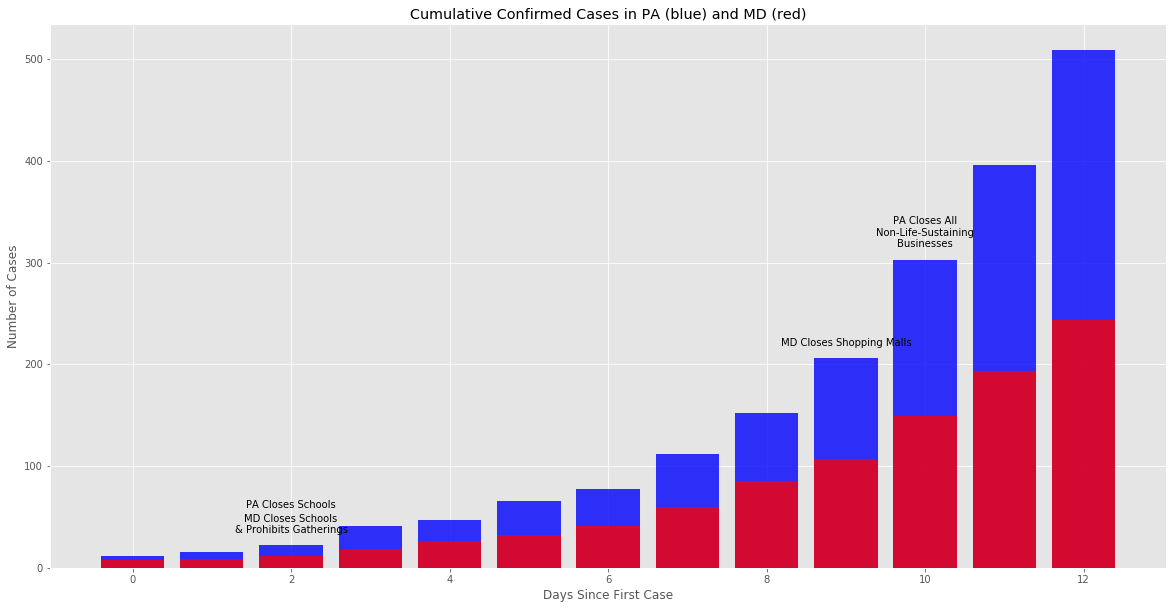

In [34]:
# Plot the data
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
fig_pa = ax.bar(pa_data["DaysSinceFirstCase"],pa_data["CumConfirmed"], color='b', alpha=0.8)
fig_md = ax.bar(md_data["DaysSinceFirstCase"],md_data["CumConfirmed"], color='r', alpha=0.8)
#fig_pa = ax.bar(pa_data["date"],pa_data["CumConfirmed"], width=np.timedelta64(16, 'h'), color='b', alpha=0.8)
#fig_md = ax.bar(md_data["date"],md_data["CumConfirmed"], width=np.timedelta64(16, 'h'), color='r', alpha=0.8)
#ax.axis(["2020-03-09", datetime.date(datetime.now()),0,np.maximum(np.max(pa_data["CumConfirmed"].values),np.max(md_data["CumConfirmed"].values))*1.10])
plt.title("Cumulative Confirmed Cases in PA (blue) and MD (red)")
plt.xlabel("Days Since First Case")
plt.ylabel("Number of Cases")

# Add tick mark at events
for i, fig in enumerate(fig_pa):
    x = fig.get_x()
    wid = fig.get_width()
    height = np.maximum(pa_data["CumConfirmed"].values[i], md_data["CumConfirmed"].values[i])
    
    md_text = False
    pa_text = False
    if md_data["GovAction"][i] != "none":
        ax.text(x + wid/2., height+10, md_data["GovAction"][i], ha='center', va='bottom', rotation=0)
        md_text = True
        
    if pa_data["GovAction"][i] != "none":
        if md_text == True:
            height = height + 25
        ax.text(x + wid/2., height+10, pa_data["GovAction"][i], ha='center', va='bottom', rotation=0)

plt.show()

In [37]:
# Extract just the new cases data from the cumulative confirmed
pa_data["NewCases"] = pa_data["CumConfirmed"].diff()
pa_data.loc[0,"NewCases"] = pa_data["CumConfirmed"][0]
md_data["NewCases"] = md_data["CumConfirmed"].diff()
md_data.loc[0,"NewCases"] = md_data["CumConfirmed"][0]

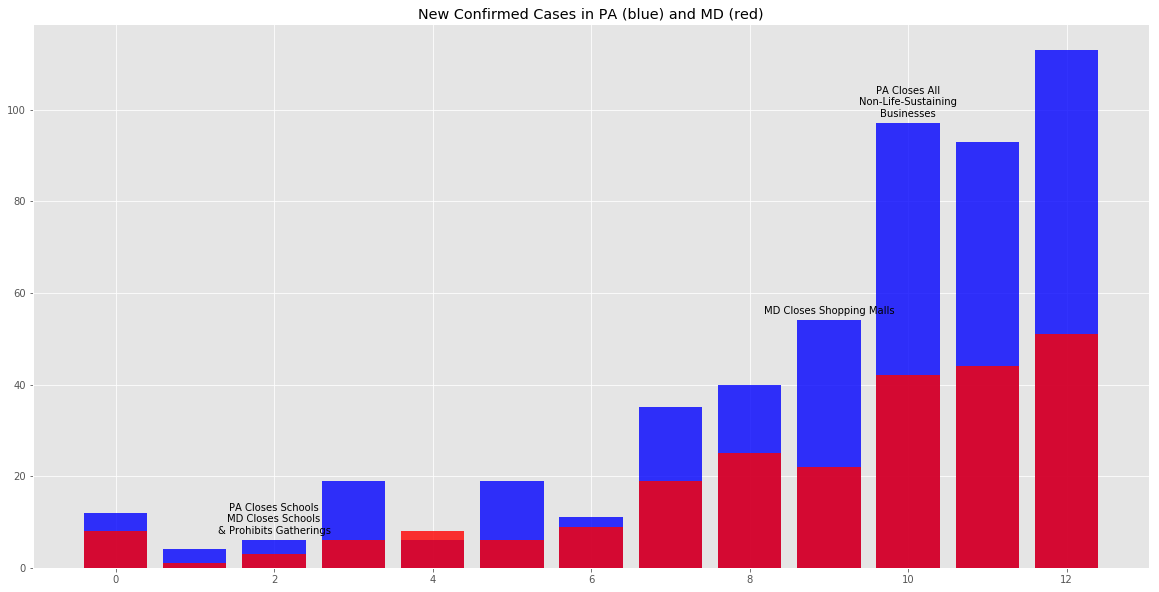

In [38]:
# Plot the new cases data
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
fig_pa = ax.bar(pa_data["DaysSinceFirstCase"],pa_data["NewCases"], color='b', alpha=0.8)
fig_md = ax.bar(md_data["DaysSinceFirstCase"],md_data["NewCases"], color='r', alpha=0.8)
#fig_pa = ax.bar(pa_data["date"],pa_data["NewCases"], width=np.timedelta64(16, 'h'), color='b', alpha=0.8)
#fig_md = ax.bar(md_data["date"],md_data["NewCases"], width=np.timedelta64(16, 'h'), color='r', alpha=0.8)
#ax.axis(["2020-03-09", datetime.date(datetime.now()),0,np.maximum(np.max(pa_data["NewCases"]),np.max(md_data["NewCases"]))*1.10])
plt.title("New Confirmed Cases in PA (blue) and MD (red)")

# Add tick mark at events
for i, fig in enumerate(fig_pa):
    x = fig.get_x()
    wid = fig.get_width()
    height = np.maximum(pa_data["NewCases"].values[i], md_data["NewCases"].values[i])
    
    md_text = False
    pa_text = False
    if md_data["GovAction"][i] != "none":
        ax.text(x + wid/2., height+1, md_data["GovAction"][i], ha='center', va='bottom', rotation=0)
        md_text = True
        
    if pa_data["GovAction"][i] != "none":
        if md_text == True:
            height = height + 5
        ax.text(x + wid/2., height+1, pa_data["GovAction"][i], ha='center', va='bottom', rotation=0)


plt.show()